# Understanding Hired Rides in NYC

## Group 10 
### Yixuan (Sharon) Qian - yq2348
### Michelle Jingyi Zhou - jz3508

## Project Setup

In [1]:
# all import statements needed for the project

import math
import os

import bs4 
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
!pip install pandas==1.4.2
!pip install pyarrow==7.0.0
import pandas as pd
import requests
import sqlalchemy as db
import numpy as np
import re
import os.path
import glob
!pip install geopandas
import geopandas
from geopandas import GeoDataFrame

import warnings
warnings.filterwarnings("ignore")

In [2]:
# any constants we might need

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

TAXI_ZONES_DIR = "data/taxi_zones"
TAXI_ZONES_SHAPEFILE = f"{TAXI_ZONES_DIR}/taxi_zones.shp"
UBER_CSV = "uber_rides_sample.csv"
WEATHER_CSV_FILES = ["2009_weather.csv", "2010_weather.csv", "2011_weather.csv", "2012_weather.csv",
                    "2013_weather.csv", "2014_weather.csv", "2015_weather.csv"]

EARTH_RADIUS = 6378.137
CRS = 4326  # coordinate reference system

# (lat, lon)
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
LGA_BOX_COORDS = ((40.763589, -73.891745), (40.778865, -73.854838))
JFK_BOX_COORDS = ((40.639263, -73.795642), (40.651376, -73.766264))
EWR_BOX_COORDS = ((40.686794, -74.194028), (40.699680, -74.165205))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

In [3]:
# Make sure the QUERY_DIRECTORY exists
try:
    os.mkdir(QUERY_DIRECTORY)
except Exception as e:
    if e.errno == 17:
        # the directory already exists
        pass
    else:
        raise

## Part 1: Data Preprocessing

For Part 1, we downloaded the Parquet files, cleaned and filtered for the relevant data, filling in missing data, and generating samples of these datasets (including Taxi, Uber, and Weather datasets).

### Calculate distance

1.rad(d) function converts numeric degrees to radians

2.distance calculation function
calculate_distance_with_coords(from_coord, to_coord) calculates the distance btween coordinates

3.add_distance_column(dataframe)

Add a column call_distance to the dataframe

In [4]:
# This function converts numeric degrees to radians
# d is diameter
def rad(d):
    return d * math.pi / 180.0

In [5]:
# This function calculates the distances between two coordinates in the following.

def calculate_distance_with_coords(from_coord, to_coord):
    """
     this function calculates the distance between two points
     using their latitude and longitude coordinates
     
     Output: distance ----- distnace between two coordinates
    """
    
    rad_lat1 = rad(from_coord[0])
    rad_lon1 = rad(from_coord[1])
    rad_lat2 = rad(to_coord[0])
    rad_lon2 = rad(to_coord[1])
    
    a = rad_lat1 - rad_lat2
    b = rad_lon1 - rad_lon2
    distance_radius = 2 * math.asin(
        math.sqrt(math.pow(math.sin(a / 2), 2) 
                  + math.cos(rad_lat1) * math.cos(rad_lat2) * math.pow(math.sin(b / 2), 2)))
    distance = distance_radius * EARTH_RADIUS
    return distance

In [6]:
def add_distance_column(df):
    
# Filter rows with valid coordinates within the NY box
    distance_list = []
    for i in range(len(df)):
        s_lat, s_lon  = df["pickup_latitude"][i], df["pickup_longitude"][i]
        e_lat, e_lon  = df["dropoff_latitude"][i], df["dropoff_longitude"][i]
        if s_lat and s_lon and e_lat and e_lon:
            outside = True
            if s_lat > NEW_YORK_BOX_COORDS[0][0] and s_lat < NEW_YORK_BOX_COORDS[1][0]:
                if e_lat > NEW_YORK_BOX_COORDS[0][0] and e_lat < NEW_YORK_BOX_COORDS[1][0]:
                    if s_lon > NEW_YORK_BOX_COORDS[0][1] and s_lon < NEW_YORK_BOX_COORDS[1][1]:
                        if e_lon > NEW_YORK_BOX_COORDS[0][1] and e_lon < NEW_YORK_BOX_COORDS[1][1]:
                            outside = False
            if outside:
                s_lat, s_lon, e_lat, e_lon = None, None, None, None
        from_coord = (s_lat, s_lon)
        to_coord = (e_lat, e_lon)
        if s_lat and s_lon and e_lat and e_lon:
            distance_list.append(calculate_distance_with_coords(from_coord, to_coord))
        else:
            distance_list.append(None)
    df["cal_distance"] = distance_list
    return df

### Use Taxi Zones Shapefile to Convert to Coordinates

1. get_latlon_from_locationID():

We load taxi zones shapefile, and add new columns.

2. convert_id_to_latlon(sample_tables)

We convert area ID column into coordinates

In [7]:
# Load taxi zones from a shapefile and add new columns.

def get_latlon_from_locationID():
    # Read the taxi zone shapefile and convert it to CRS
    # gdf is GeoDataFrame
    gdf = geopandas.read_file("taxi_zones.shp")
    gdf = gdf.to_crs(CRS)
    
    # Get the lon and lat of the centroid of each  zone
    lon = gdf.centroid.x
    lat = gdf.centroid.y
    
    # Add new columns to the dataframe to store the lon and lat
    gdf["lon"] = lon
    gdf["lat"] = lat
    return gdf


In [8]:
# In the following codes, we convert area ID column into  coordinates

def convert_id_to_latlon(samples_df):
    """
    Convert area ID column into two coordinates
    """
    gdf = get_latlon_from_locationID()

    def get_coords(location_id):
        if location_id < 264 and location_id in gdf["LocationID"].values:
            row_index = gdf[gdf["LocationID"] == location_id].index.values[0]
            lon, lat = float(gdf["lon"][row_index]), float(gdf["lat"][row_index])

            if (
                NEW_YORK_BOX_COORDS[0][0] < lat < NEW_YORK_BOX_COORDS[1][0]
                and NEW_YORK_BOX_COORDS[0][1] < lon < NEW_YORK_BOX_COORDS[1][1]
            ):
                return lon, lat

        return None, None

    start_coords = samples_df["PULocationID"].apply(get_coords)
    end_coords = samples_df["DOLocationID"].apply(get_coords)

    samples_df["pickup_longitude"] = [coord[0] for coord in start_coords]
    samples_df["pickup_latitude"] = [coord[1] for coord in start_coords]
    samples_df["dropoff_longitude"] = [coord[0] for coord in end_coords]
    samples_df["dropoff_latitude"] = [coord[1] for coord in end_coords]
    return samples_df

### Process Taxi Data

1. This function, get_taxi_parquet_urls(), programmatically downloads the Yellow Taxi Parquet files for a specific date range 2009-01 and 2015-06 from the website. it returns a list that contains all taxi data url in TAXI_URL ""https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

2. In process_datetime(samples_df), we modified column type for date column, and we also added columns for time data

3. In get_and_clean_month_taxi_data(url), we added latitude and logitude from taxi_zones. We also added pickup_latitude, dropoff_latitude, dropoff_latitude and dropoff_longitude as columns to the dataframe for convenient calculation

4. From get_and_clean_taxi_data(), we download Parquet files, get some sample from these files, Clean the dataframe according to existing location IDs.

5. Lastly, we processed and downloaded taxi_data (if first time). 

In [9]:
def get_taxi_parquet_urls():

    parquet_urls = []
    response = requests.get(url=TAXI_URL)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        links = soup.find_all('a', href=True)
        for link in links:
            url = link['href']
            if 'yellow_tripdata' in url and '.parquet' in url:
                date_str = url.split('/')[-1].split('_')[-1].split('.')[0]
                year = int(date_str[:4])
                month = int(date_str[4:6])
                if year < 2015 or (year == 2015 and month <= 6):
                    parquet_urls.append(url)
    return parquet_urls

In [10]:
def process_datetime(samples_df):
    """
    In the following codes, we modified column type for date column, and we also added columns for time data
    
    """
    if "tpep_pickup_datetime" in samples_df.columns:
        samples_df['tpep_pickup_datetime'] = pd.to_datetime(samples_df['tpep_pickup_datetime'])
        samples_df['tpep_dropoff_datetime'] = pd.to_datetime(samples_df['tpep_dropoff_datetime'])

        datetime_columns = {
            'DATE': samples_df['tpep_pickup_datetime'],
            'YEAR': samples_df['tpep_pickup_datetime'].dt.year.astype(int),
            'MONTH': samples_df['tpep_pickup_datetime'].dt.month.astype(int),
            'DAY': samples_df['tpep_pickup_datetime'].dt.day.astype(int),
            'HOUR': samples_df['tpep_pickup_datetime'].dt.hour.astype(int),
            'WEEK': samples_df['tpep_pickup_datetime'].dt.dayofweek + 1 
        }
    else:
        datetime_columns = {
            'tpep_pickup_datetime': None,
            'YEAR': None,
            'MONTH': None,
            'DAY': None,
            'HOUR': None,
            'WEEK': None
        } 
    samples_df = samples_df.assign(**datetime_columns) 
    return samples_df

In [11]:
def get_and_clean_month_taxi_data(url):
    """
    Download, read, sample, and clean one month of taxi data

    Arguments:
    url -- a url for downloading a specific month's taxi parquet file

    Returns:
    cleaned_data -- a DataFrame containing cleaned taxi data for one month
    """
    response = requests.get(url, stream=True)
    file_name = url.split("/")[-1]

    if not os.path.exists(file_name):
        with open(file_name, 'wb') as f:
            for chunk in response.iter_content(chunk_size=1024):
                f.write(chunk)

    columns_by_year = {
        '2011_2015': ["tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count", "trip_distance", "pickup_longitude",
                  "pickup_latitude", "dropoff_longitude", "dropoff_latitude", "tip_amount"],
        '2010': ["pickup_datetime", "dropoff_datetime", "passenger_count", "trip_distance", "pickup_longitude", "pickup_latitude",
               "dropoff_longitude", "dropoff_latitude", "tip_amount"],
        '2009': ["Trip_Pickup_DateTime", "Trip_Dropoff_DateTime", "Passenger_Count", "Trip_Distance", "Start_Lon", "Start_Lat",
               "End_Lon", "End_Lat", "Tip_Amt"]
    }
    
    print('read data from ', file_name)
    raw_data = pd.read_parquet(file_name)
    # to speed up the data clean process
    raw_data = raw_data.sample(4000)
    raw_data.reset_index(inplace=True)

    year_key = '2011_2015' if not re.search(r"2009|2010", file_name) else '2010' if re.search(r"2010", file_name) else '2009'

    if year_key == '2011_2015':
        raw_data = convert_id_to_latlon(raw_data)

    cleaned_data = raw_data[columns_by_year[year_key]]
    unified_column_names = {columns_by_year[year_key][i]: columns_by_year['2011_2015'][i] for i in range(len(columns_by_year[year_key]))}
    cleaned_data.rename(columns=unified_column_names, inplace=True)

    cleaned_data[columns_by_year['2011_2015'][:8]] = cleaned_data[columns_by_year['2011_2015'][:8]].replace(0.0, None)
    cleaned_data.dropna(inplace=True)
    
    #generate a sampling of Taxi data that's roughly equal to the Uber dataset
    #Uber, 200,000/78=2564. 
    cleaned_data = cleaned_data.sample(2564)
    cleaned_data.reset_index(inplace=True)

    cleaned_data = process_datetime(cleaned_data)
    cleaned_data = add_distance_column(cleaned_data)
    cleaned_data.drop(["index"], axis=1, inplace=True)

    return cleaned_data


In [12]:
def get_and_clean_taxi_data():
    all_taxi_dataframes = []
    
    all_parquet_urls = get_taxi_parquet_urls()
    # print(all_parquet_urls)
    for parquet_url in all_parquet_urls:
        
        dataframe = get_and_clean_month_taxi_data(parquet_url)
                
        all_taxi_dataframes.append(dataframe)
    
    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_taxi_dataframes)
    return taxi_data


In [13]:
if os.path.exists('/content/taxi_clean_data.csv'): 
    taxi_data = pd.read_csv('/content/taxi_clean_data.csv')
    taxi_data = taxi_data.loc[:, ~taxi_data.columns.str.contains('^Unnamed')]
else:
    taxi_data = get_and_clean_taxi_data()

read data from  yellow_tripdata_2015-01.parquet
read data from  yellow_tripdata_2015-02.parquet
read data from  yellow_tripdata_2015-03.parquet
read data from  yellow_tripdata_2015-04.parquet
read data from  yellow_tripdata_2015-05.parquet
read data from  yellow_tripdata_2015-06.parquet
read data from  yellow_tripdata_2015-07.parquet
read data from  yellow_tripdata_2015-08.parquet
read data from  yellow_tripdata_2015-09.parquet
read data from  yellow_tripdata_2015-10.parquet
read data from  yellow_tripdata_2015-11.parquet
read data from  yellow_tripdata_2015-12.parquet
read data from  yellow_tripdata_2014-01.parquet
read data from  yellow_tripdata_2014-02.parquet
read data from  yellow_tripdata_2014-03.parquet
read data from  yellow_tripdata_2014-04.parquet
read data from  yellow_tripdata_2014-05.parquet
read data from  yellow_tripdata_2014-06.parquet
read data from  yellow_tripdata_2014-07.parquet
read data from  yellow_tripdata_2014-08.parquet
read data from  yellow_tripdata_2014-09.

### Processing Uber Data
1. load_and_clean_uber_data:
This function load data from Uber csv file, and add columns to the pd df 
and load data from input file and add date columns to it

2. get_uber_data():
We loaded, filerted, and cleaned Uber data, we also added an another column for distance traveled during each Uber ride
 
3. We installed two packages.

4. We processed Uber data.

In [14]:
def load_and_clean_uber_data(csv_file):
    """
    Load data from Uber csv file, and add columns to the pd df 
    and load data from input file and add date columns to it

    """
    # Load data from Uber CSV file
    pd_df = pd.read_csv(csv_file)
    
    # Convert pickup datetime column to pd datetime format
    pd_df['pickup_datetime'] = pd.to_datetime(pd_df['pickup_datetime'])
    
    # get year, month, week, day, hour from pickup datetime column
    pd_df['YEAR'] = pd_df['pickup_datetime'].dt.year.astype(int)
    pd_df['MONTH'] = pd_df['pickup_datetime'].dt.month.astype(int)
    pd_df['WEEK'] = pd_df['pickup_datetime'].dt.dayofweek + 1
    pd_df['DAY'] = pd_df['pickup_datetime'].dt.day.astype(int)
    pd_df['HOUR'] = pd_df['pickup_datetime'].dt.hour.astype(int)
    
    pd_df = pd_df.reset_index(drop=True)
    
    return pd_df

In [15]:
def get_uber_data():
    """
    We loaded, filerted, and cleaned Uber data, we also added an another column for distance traveled during each Uber ride
    
    """
    uber_dataframe = load_and_clean_uber_data(UBER_CSV)
    
    valid_columns = ["fare_amount", "pickup_datetime", "pickup_longitude", "pickup_latitude",
                     "dropoff_longitude", "dropoff_latitude"]
    
    # put 0.0 values in valid columns with NaN
    uber_dataframe[valid_columns] = uber_dataframe[valid_columns].replace(0.0, None)
    
    # Drop rows with NaN values in valid columns
    uber_dataframe.dropna(subset=valid_columns, inplace=True)
    uber_dataframe = uber_dataframe.reset_index(drop=True)
    
    # Add a new column for the distance traveled during each Uber ride
    add_distance_column(uber_dataframe)
    
    valid_columns.append("cal_distance")
    valid_columns.remove("fare_amount")
    
    # Drop rows with NaN values
    uber_dataframe.dropna(subset=valid_columns, inplace=True)
    uber_dataframe = uber_dataframe.drop(["key", "fare_amount"], axis=1)

    return uber_dataframe

In [16]:
!pip install pyarrow
!pip install fastparquet

  Using cached pandas-2.0.1-cp39-cp39-macosx_10_9_x86_64.whl (11.8 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.2
    Uninstalling pandas-1.4.2:
      Successfully uninstalled pandas-1.4.2


In [18]:
uber_data = get_uber_data()
uber_data.head()

,Unnamed: 0,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,YEAR,MONTH,WEEK,DAY,HOUR,cal_distance
0,24238194,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,4,7,19,1.685209
1,27835199,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.99471,40.750325,1,2009,7,5,17,20,2.460343
2,44984355,2009-08-24 21:45:00+00:00,-74.005043,40.74077,-73.962565,40.772647,1,2009,8,1,24,21,5.042019
3,25894730,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,5,26,8,1.663545
4,17610152,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,4,28,17,4.480464


### Processing Weather Data

1. function get_all_weather_csvs(directory): We get weather csv from our directory.

2. function clean_month_weather_data_hourly(csv_file): We cleaned hourly weather data (see specifics in comments in the corresponding cell)

3. function clean_month_weather_data_daily(csv_file): We cleaned daily weather data (see specifics in comments in the cell)

4. function load_and_clean_weather_data(): We loaded weather data.

5. After that, we checked the data.

In [19]:
def get_all_weather_csvs(directory):
    csv_files = []
    for file in os.listdir(directory):
        if file.endswith(".csv") and "weather" in file.lower():
            csv_files.append(os.path.join(directory, file))
    return csv_files

In [20]:
def clean_month_weather_data_hourly(csv_file):

    columns_to_keep = ["DATE", "HourlyPrecipitation", "HourlyWindSpeed"]
    weather_data = pd.read_csv(csv_file, usecols=columns_to_keep)

    # Replace missing values in HourlyPrecipitation with 0.0
    weather_data["HourlyPrecipitation"] = weather_data["HourlyPrecipitation"].fillna(0)

    # Convert DATE column to datetime and extract year, month, day, and hour
    weather_data["DATE"] = pd.to_datetime(weather_data["DATE"])
    weather_data["YEAR"] = weather_data["DATE"].dt.year.astype(int)
    weather_data["MONTH"] = weather_data["DATE"].dt.month.astype(int)
    weather_data["WEEK"] = weather_data["DATE"].dt.dayofweek + 1
    weather_data["DAY"] = weather_data["DATE"].dt.day.astype(int)
    weather_data["HOUR"] = weather_data["DATE"].dt.hour.astype(int)


    # gethourly weather data for each day
    hourly_weather = []
    hourly_weather_columns = list(weather_data.columns)
    date_string = ""
    for i in range(weather_data.shape[0]):
        tmp_date_string = str(weather_data.iloc[i, :]["YEAR"]) + str(weather_data.iloc[i, :]["MONTH"]) + str(weather_data.iloc[i, :]["DAY"]) + str(weather_data.iloc[i, :]["HOUR"])
        if tmp_date_string == date_string:
            continue
        else:
            hourly_weather.append(weather_data.iloc[i, :].to_list())
            date_string = tmp_date_string

    # Create a new df from the hourly weather data and ignore any rows with no values
    hourly_weather_data = pd.DataFrame(hourly_weather, columns=hourly_weather_columns)
    hourly_weather_data.dropna(inplace=True)

    return hourly_weather_data

In [21]:
def clean_month_weather_data_daily(csv_file):
    
    columns_to_keep = ["DATE", "DailyPrecipitation", "DailyAverageWindSpeed", "REPORT_TYPE"]
    
    weather_data = pd.read_csv(csv_file, usecols=columns_to_keep)
    weather_data.dropna(subset=["DailyAverageWindSpeed"], inplace=True)
    weather_data[["DailyPrecipitation"]] = weather_data[["DailyPrecipitation"]].fillna(0)
    
    weather_data['DATE'] = pd.to_datetime(weather_data['DATE'])
    weather_data['YEAR'] = weather_data['DATE'].dt.year.astype(int)
    weather_data['MONTH'] = weather_data['DATE'].dt.month.astype(int)
    weather_data["WEEK"] = weather_data['DATE'].dt.dayofweek + 1
    weather_data['DAY'] = weather_data['DATE'].dt.day.astype(int)

    
    date_str = ""
    daily_weather = []
    daily_weather_columns = list(weather_data.columns)
    for i in range(weather_data.shape[0]):
        tmp_date_str = str(weather_data.iloc[i,:]["YEAR"]) + str(weather_data.iloc[i,:]["MONTH"]) + str(weather_data.iloc[i,:]["DAY"])
        if tmp_date_str == date_str:
            continue
        else:
            daily_weather.append(weather_data.iloc[i,:].to_list())
            date_str = tmp_date_str 
    
    daily_weather_data = pd.DataFrame(daily_weather, columns=daily_weather_columns)
    
    return daily_weather_data

In [22]:
def load_and_clean_weather_data():
    
    hourly_dataframes = []
    daily_dataframes = []
        
    for csv_file in WEATHER_CSV_FILES:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    
    return hourly_data, daily_data

In [23]:
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()

In [24]:
hourly_weather_data.head()

,DATE,HourlyPrecipitation,HourlyWindSpeed,YEAR,MONTH,WEEK,DAY,HOUR
0,2009-01-01 00:51:00,0,18.0,2009,1,4,1,0
1,2009-01-01 01:51:00,0,18.0,2009,1,4,1,1
2,2009-01-01 02:51:00,0,18.0,2009,1,4,1,2
3,2009-01-01 03:51:00,0,8.0,2009,1,4,1,3
4,2009-01-01 04:51:00,0,11.0,2009,1,4,1,4


In [25]:
daily_weather_data.head()

,DATE,REPORT_TYPE,DailyAverageWindSpeed,DailyPrecipitation,YEAR,MONTH,WEEK,DAY
0,2012-07-31 23:59:00,SOD,3.8,0.00,2012,7,2,31
1,2012-08-01 23:59:00,SOD,2.3,0.64,2012,8,3,1
2,2012-08-02 23:59:00,SOD,2.7,0.00,2012,8,4,2
3,2012-08-03 23:59:00,SOD,3.5,0.00,2012,8,5,3
4,2012-08-04 23:59:00,SOD,3.1,0.00,2012,8,6,4


## Part 2: Storing Cleaned Data
In Part 2, we took the sample datasets generated from Part 1, and populated a SQL database with tables generated from the datasets.

1. We created a database.
2. we create that required schema.sql file.
3. We createed four tables (as mentioned in the prompt).


In [26]:
engine = db.create_engine(DATABASE_URL)

In [27]:
HOURLY_WEATHER_SCHEMA = """
create table if not exists hourly_weather(
  hid int primary key, 
  date timestamp, 
  year int, 
  month int, 
  week int, 
  hour int, 
  hourlyPrecipitation float, 
  hourlyWindSpeed float
)
"""
DAILY_WEATHER_SCHEMA = """
create table if not exists daily_weather(
  did int primary key,
  date timestamp,
  dailyPrecipitation float,
  dailyAverageWindSpeed float,
  year int,
  month int,
  day int, 
  week int 
)
"""

TAXI_TRIPS_SCHEMA = """
create table if not exists taxi_trip(
  tid int primary key,
  date timestamp,
  tpep_pickup_datetime timestamp,
  tpep_dropoff_datetime timestamp,
  trip_distance float,
  tip_amount float,
  passenger_count int,
  pickup_longitude float,
  pickup_latitude float,
  dropoff_longitude float,
  dropoff_latitude float,
  cal_distance float,
  year int,
  month int,
  day int,
  hour int,
  week int
)
"""

UBER_TRIPS_SCHEMA = """
create table if not exists uber_trip(
  uid int primary key,
  pickup_datetime timestamp,
  pickup_longitude float,
  pickup_latitude float,
  dropoff_longitude float,
  dropoff_latitude float,
  passenger_count int,
  year int,
  month int,
  day int,
  week int,
  hour int,
  cal_distance float
)
"""

In [28]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [29]:
# create the tables with the schema files
from sqlalchemy import text
conn = engine.connect()
conn.execute(text('drop table if exists taxi_trip'))
conn.execute(text('drop table if exists uber_trip'))
conn.execute(text('drop table if exists hourly_weather'))
conn.execute(text('drop table if exists daily_weather'))
conn.execute(text(HOURLY_WEATHER_SCHEMA))
conn.execute(text(DAILY_WEATHER_SCHEMA))
conn.execute(text(TAXI_TRIPS_SCHEMA))
conn.execute(text(UBER_TRIPS_SCHEMA))

### Add Data to Database

In this section, we add dataframes to database.

In [30]:
def write_dataframes_to_table(table_to_df_dict):
    for table in table_to_df_dict.keys():
        table_to_df_dict[table].to_sql(table, engine, if_exists='replace')

In [31]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data,
}

In [32]:
write_dataframes_to_table(map_table_name_to_dataframe)

## Part 3: Understanding the Data

In Part 3, we crafted a set of SQL queries to develop a better understanding of the dataset we are working with.

In [33]:
# Helper function to write the queries to file
def write_query_to_file(query, outfile):
    with open(f'{QUERY_DIRECTORY}/{outfile}', 'w') as f:
        f.write(query)

### Query 1

For 01-2009 through 06-2015, show the popularity of Yellow Taxi rides for each hour of the day.

In [34]:
QUERY_1_FILENAME = "Taxi_Popularity_hour.sql"
QUERY_1 = """
SELECT HOUR, COUNT(*) as count 
FROM taxi_trips
WHERE tpep_pickup_datetime between '2009-01-01' and '2015-06-30'
GROUP BY HOUR 
ORDER BY count DESC 
"""

In [35]:
engine.execute(QUERY_1).fetchall()

[(19, 12608),
 (18, 12090),
 (20, 11829),
 (21, 11378),
 (22, 10975),
 (14, 10139),
 (23, 9992),
 (12, 9856),
 (17, 9823),
 (15, 9708),
 (13, 9648),
 (9, 9358),
 (11, 9295),
 (8, 9098),
 (10, 9014),
 (16, 8189),
 (0, 7915),
 (7, 7175),
 (1, 5854),
 (2, 4378),
 (6, 4039),
 (3, 3266),
 (4, 2350),
 (5, 1930)]

In [36]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

### Query 2
For the same time frame, show the popularity of Uber rides for each day of the week.

In [37]:
QUERY_2_FILENAME = "Uber_Popularity_day.sql"

QUERY_2 = """
SELECT WEEK, COUNT(*) as count 
FROM uber_trips
WHERE pickup_datetime >= '2009-01-01' and pickup_datetime <= '2015-06-30'
GROUP BY WEEK 
ORDER BY count DESC 
"""
query2_result = conn.execute(text(QUERY_2)).fetchall()
query2_result

[(5, 30166),
 (6, 29598),
 (4, 29338),
 (3, 28328),
 (2, 27461),
 (7, 25834),
 (1, 24681)]

In [38]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

### Query 3
What is the 95% percentile of distance traveled for all hired trips during July 2013?

In [39]:
QUERY_3_FILENAME = "95distance_traveled_july2013.sql"

QUERY_3 = """
WITH t as (
  SELECT cal_distance FROM taxi_trips where tpep_pickup_datetime >= '2013-07-01' and tpep_pickup_datetime <= '2013-07-31'
  UNION ALL
  SELECT cal_distance FROM uber_trips where pickup_datetime >= '2013-07-01' and pickup_datetime <= '2013-07-31' 
) 
SELECT cal_distance from t
ORDER BY cal_distance asc
LIMIT 1
OFFSET (SELECT COUNT(*) FROM t) * 95/100 - 1;
"""
query3_result = conn.execute(text(QUERY_3)).fetchall()
query3_result

[(10.423625774419417,)]

In [40]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

### Query 4
What were the top 10 days with the highest number of hired rides for 2009, and what was the
average distance for each day?

In [41]:
QUERY_4_FILENAME = "top_10_days_and_average_distance.sql"

QUERY_4 = """
WITH t as (
  SELECT date(tpep_pickup_datetime) as date, trip_distance from taxi_trips
  UNION ALL
  SELECT date(pickup_datetime) as date, cal_distance as trip_distance from uber_trips 
) 
SELECT date, COUNT(*), avg(trip_distance) FROM t
WHERE date >= '2009-01-01' and date <= '2009-12-31'
GROUP by date
ORDER BY count(*) desc
limit 10
"""
query4_result = conn.execute(text(QUERY_4)).fetchall()
query4_result

[('2009-12-11', 240, 2.6896319462023186),
 ('2009-10-23', 233, 2.555799910397601),
 ('2009-01-31', 221, 2.7774606402801587),
 ('2009-02-20', 220, 2.8517443082474214),
 ('2009-07-23', 219, 3.192629464541998),
 ('2009-04-04', 215, 2.733749732063346),
 ('2009-03-20', 211, 2.9687595980595147),
 ('2009-12-09', 210, 2.80447320060552),
 ('2009-12-05', 210, 2.6000365194543185),
 ('2009-08-14', 210, 3.2417550224292038)]

In [42]:
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

### Query 5
Which 10 days in 2014 were the windiest on average, and how many hired trips were made on
those days?

In [43]:
QUERY_5_FILENAME = "10_windiest_2014_and_trips_amount.sql"

QUERY_5 = """
WITH t1 as (
  SELECT date(date) as date FROM daily_weather 
  WHERE date >= '2014-01-01' and date <= '2014-12-31'
  ORDER BY dailyAverageWindSpeed desc
  LIMIT 10  
),
t2 as (
  SELECT date(tpep_pickup_datetime) as date from taxi_trips where tpep_pickup_datetime >= '2014-01-01' and tpep_pickup_datetime <= '2014-12-31'
  UNION ALL
  SELECT date(pickup_datetime) as date from uber_trips where pickup_datetime >= '2014-01-01' and pickup_datetime <= '2014-12-31'
), 
t3 as (
  SELECT date, COUNT(*) as trip_count FROM t2 GROUP BY date
)
SELECT t1.date, t3.trip_count FROM t1 LEFT JOIN t3 on t1.date = t3.date
"""
query5_result = conn.execute(text(QUERY_5)).fetchall()
query5_result

[('2014-03-13', 190),
 ('2014-01-07', 163),
 ('2014-02-13', 134),
 ('2014-01-02', 123),
 ('2014-03-26', 174),
 ('2014-12-07', 165),
 ('2014-12-08', 170),
 ('2014-03-29', 199),
 ('2014-11-02', 156),
 ('2014-01-03', 84)]

In [44]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

### Query 6
During Hurricane Sandy in NYC (Oct 29-30, 2012), plus the week leading up and the week after,
how many trips were taken each hour, and for each hour, how much precipitation did NYC
receive and what was the sustained wind speed?

The result should be a list of roughly 384 tuples, where each tuple is an entry for every single hour of the given date range, even if no rides were taken, no precipitation was measured, or there was no wind. Each tuple should have four items: a string for the date and hour, an int for the number of hired rides in that hour, the float for the total precipitation for that hour, and a float for the average wind speed for that hour. The list of tuples should be ordered by date+hour, ascending.

In [45]:
QUERY_6_FILENAME = "Sandy_perhour_trips_precipitation.sql"

QUERY_6 = """
WITH t1 as (
  SELECT date(date) as day, hour as time, sum(hourlyPrecipitation) as precipitation, avg(hourlyWindSpeed) as windSpeed FROM hourly_weather 
  WHERE date >= '2012-10-22' and date <= '2012-11-06'
  GROUP BY day, time  
),
t2 as (
  SELECT date(tpep_pickup_datetime) as date, hour as time from taxi_trips
  WHERE date >= '2012-10-22' and date <= '2012-11-06'
  UNION ALL
  SELECT date(pickup_datetime) as date, hour as time from uber_trips
  WHERE date >= '2012-10-22' and date <= '2012-11-06'
), 
t3 as (
  SELECT date, time, count(*) as trip_count from t2 group by date, time
)
SELECT t1.day, t1.time, t3.trip_count, t1.Precipitation, t1.windSpeed 
FROM t1 left join t3 on t1.time = t3.time and t1.day = t3.date
ORDER BY t1.day
"""
query6_result = conn.execute(text(QUERY_6)).fetchall()
query6_result

[('2012-10-22', 0, 2, 0.0, 7.0),
 ('2012-10-22', 1, 2, 0.0, 5.0),
 ('2012-10-22', 2, 2, 0.0, 7.0),
 ('2012-10-22', 3, 2, 0.0, 0.0),
 ('2012-10-22', 4, 1, 0.0, 0.0),
 ('2012-10-22', 5, 3, 0.0, 0.0),
 ('2012-10-22', 6, 5, 0.0, 5.0),
 ('2012-10-22', 7, 7, 0.0, 3.0),
 ('2012-10-22', 8, 3, 0.0, 3.0),
 ('2012-10-22', 9, 14, 0.0, 5.0),
 ('2012-10-22', 12, 8, 0.0, 11.0),
 ('2012-10-22', 14, 4, 0.0, 7.0),
 ('2012-10-22', 15, 5, 0.0, 6.0),
 ('2012-10-22', 16, 9, 0.0, 3.0),
 ('2012-10-22', 17, 9, 0.0, 7.0),
 ('2012-10-22', 18, 16, 0.0, 5.0),
 ('2012-10-22', 19, 8, 0.0, 5.0),
 ('2012-10-22', 20, 10, 0.0, 3.0),
 ('2012-10-22', 21, 2, 0.0, 0.0),
 ('2012-10-22', 22, 11, 0.0, 3.0),
 ('2012-10-22', 23, 1, 0.0, 3.0),
 ('2012-10-23', 0, 6, 0, 3.0),
 ('2012-10-23', 1, 2, 0, 0.0),
 ('2012-10-23', 2, None, 0, 3.0),
 ('2012-10-23', 3, None, 0, 0.0),
 ('2012-10-23', 4, None, 0, 3.0),
 ('2012-10-23', 5, 3, 0, 0.0),
 ('2012-10-23', 6, 6, 0, 0.0),
 ('2012-10-23', 7, 11, 0, 0.0),
 ('2012-10-23', 8, 9, 0, 0.0),
 (

In [46]:
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

## Part 4: Visualizing the Data

In Part 4, we created several visualizations to enhance our understanding of the datasets. The details of the graphs are shown in the prompts below.

### Visualization 1

Create an appropriate visualization for the first query/question in part 3

In [47]:
# use a more descriptive name for your function
def cab_popular_hour(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    plt.bar([a[0] for a in dataframe], [a[1] for a in dataframe])
    plt.xlabel('Hour')
    plt.ylabel('Number of travels')
    plt.title('Most popular hour for Yellow Taxi')
    plt.show()

In [48]:
def get_data_for_cab_popular_hour():
    result = conn.execute(text(QUERY_1)).fetchall()
    return result

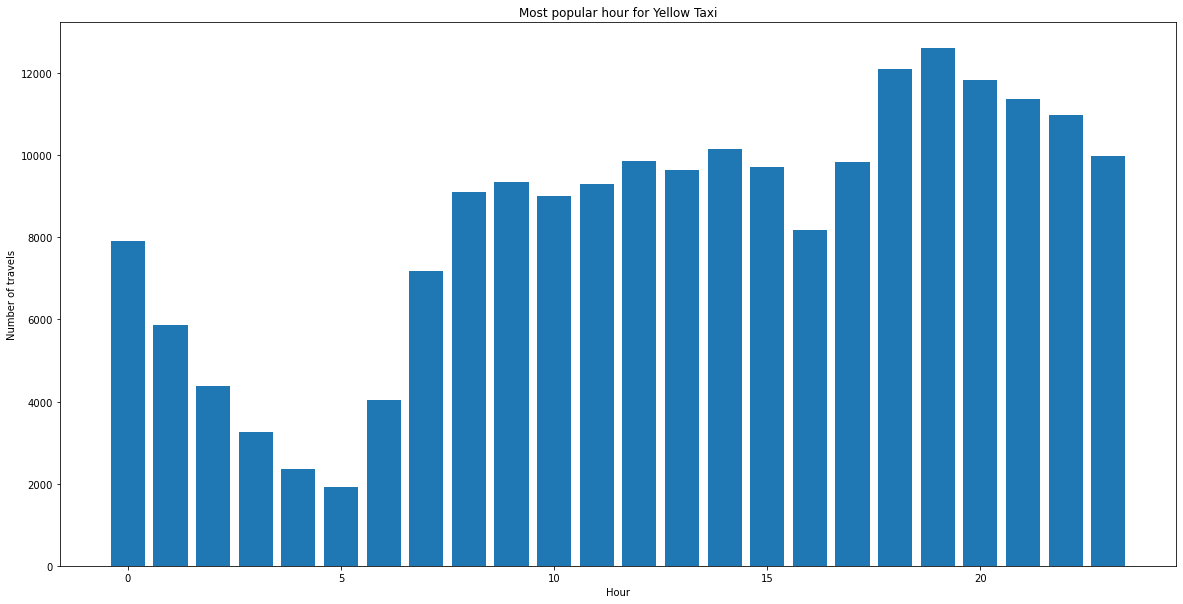

In [49]:
Vis1_dataframe = get_data_for_cab_popular_hour()
cab_popular_hour(Vis1_dataframe)

### Visualization 2
Create a visualization that shows the average distance traveled per month (regardless of
year - so group by each month) for both taxis and Ubers combined. Include the 90%
confidence interval around the mean in the visualization.

In [50]:
def plot_visual_distance_avg(df):
    day_list = [a[0] for a in df]
    count_list = [a[1] for a in df]
    upbound = [a[1] + math.sqrt(a[2]/a[3]) * 1.645 for a in df]
    lowbound = [a[1] - math.sqrt(a[2]/a[3]) * 1.645 for a in df]
    plt.plot(day_list, count_list, 'b-', label='')
    plt.plot(day_list, upbound, 'r-.', label='Upper bound')
    plt.plot(day_list, lowbound, 'g-.', label='Lower bound')
    plt.xlabel('Month')
    plt.ylabel('Average distance traveled')
    plt.title('Average distance traveled per month')
    plt.legend()
    plt.show()

In [51]:
def get_data_for_visual_distance_avg():
    # get the average distance, standard deviation, and count of trips per month
    QUERY_V2 = '''
    with t as(
        SELECT month, cal_distance FROM taxi_trips
        union all
        SELECT month, cal_distance FROM uber_trips
    )
    SELECT month, avg(cal_distance), ((sum(cal_distance)*sum(cal_distance) - sum(cal_distance * cal_distance))/((count(*)-1)*(count(*)))), count(*) 
    FROM t 
    GROUP BY month 
    '''
    result = conn.execute(text(QUERY_V2)).fetchall()
    return result

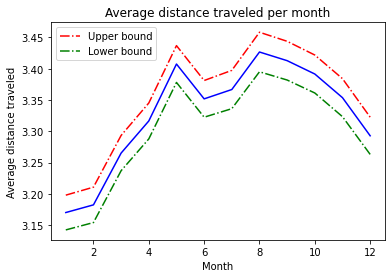

In [52]:
v2_df = get_data_for_visual_distance_avg()
plot_visual_distance_avg(v2_df)

### Visualization 3
Define three lat/long coordinate boxes around the three major New York airports: LGA,
JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares
what day of the week was most popular for drop offs for each airport.

In [53]:
def popular_dropoffs_day_airport(dataframe, title, index, axis):
  # Plot data into graph
    day = [d[0] for d in dataframe]
    count = [d[1] for d in dataframe]
    axis.bar(day, count)
    axis.set_title(title)

In [54]:
location_map = {
    'LGA_box_lat': [40.765396, 40.784441],
    'LGA_box_lon': [-73.900051, -73.858852],
    'JFK_box_lat': [40.624898, 40.664233],
    'JFK_box_lon': [-73.823318, -73.744526],
    'EWR_box_lat': [40.669572, 40.710247],
    'EWR_box_lon': [-74.191961, -74.153681]
}
def get_data_for_popular_dropoffs_day_airport(city):
  # get the traffic flow data for city
    QUERY = f"\
      with t as ( \
        SELECT week, dropoff_longitude as lon, dropoff_latitude as lat FROM taxi_trips \
        UNION ALL  \
        SELECT week, dropoff_longitude as lon, dropoff_latitude as lat FROM uber_trips \
      ) \
      SELECT week, COUNT(*) from t \
      where lat between {location_map[city+'_box_lat'][0]} and {location_map[city+'_box_lat'][1]}\
      and lon between {location_map[city+'_box_lon'][0]} and {location_map[city+'_box_lon'][1]}\
      GROUP BY week"
    result = conn.execute(text(QUERY)).fetchall()
    return result

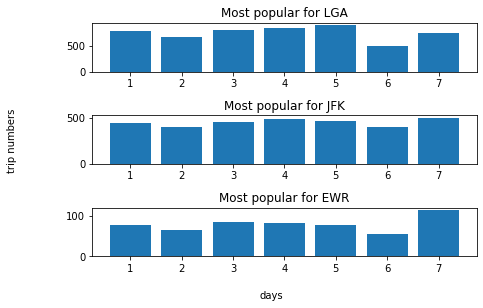

In [55]:
cites = ['LGA', 'JFK', 'EWR']
fig, axis = plt.subplots(3, 1)
for i, city in enumerate(cites):
    df = get_data_for_popular_dropoffs_day_airport(city)
    popular_dropoffs_day_airport(df, 'Most popular for ' + city, i+1, axis[i])
fig.text(0.5, -0.04, "days", ha="center", va="center")
fig.text(-0.1, 0.5, "trip numbers", ha='center', va="center", rotation='vertical')
fig.tight_layout()
plt.show()

### Visualization 4

Create a heatmap of all hired trips over a map of the area. Consider using Folium or
KeplerGL or another library that helps generate geospatial visualizations.
Depending on the library you use, the visualization may not render when viewing on
GitHub (after you’ve pushed your code). If that’s the case, please include a screenshot in
your repository.

In [56]:
!pip install keplergl

In [57]:
from keplergl import KeplerGl

def all_trips_heatmap(dataframe):
    map_ = KeplerGl(height=600)
    map_.add_data(data=dataframe, name='All Trips Heatmap')
    return map_

In [58]:
def get_data_for_all_trips_heatmap():
    QUERY = """
      SELECT dropoff_latitude, dropoff_longitude FROM taxi_trips 
      UNION all 
      SELECT dropoff_latitude, dropoff_longitude FROM uber_trips   
    """
    result = conn.execute(text(QUERY)).fetchall()
    result = pd.DataFrame(result)
    return result

In [59]:
heatmap_dataframe = get_data_for_all_trips_heatmap()
map_ = all_trips_heatmap(heatmap_dataframe)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


### Visualization 5

Create a scatter plot that compares tip amount versus distance for Yellow Taxi rides. You
may remove any outliers how you see fit.

In [60]:
def plot_visual_tip_distance(dataframe):
    plt.scatter([d[0] for d in dataframe], [d[1] for d in  dataframe])
    plt.xlabel("Tip Amount")
    plt.ylabel("Distance")
    plt.title("Tip amount VS. Distance")   
    plt.show()

In [61]:
def get_data_for_visual_tip_distance():
    QUERY = """
      SELECT tip_amount, cal_distance FROM taxi_trips
      where tip_amount between 0 and 50 and cal_distance between 0 and 50
    """
    result = conn.execute(text(QUERY)).fetchall()
    return result

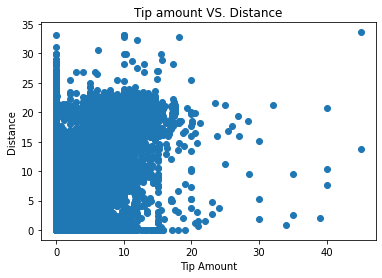

In [62]:
vis5_dataframe = get_data_for_visual_tip_distance()
plot_visual_tip_distance(vis5_dataframe)

### Visualization 6
Create another scatter plot that compares tip amount versus precipitation amount for
Yellow Taxi rides. You may remove any outliers how you see fit.

In [63]:
def tip_precipitation(dataframe):
    plt.scatter([d[0] for d in dataframe], [d[1] for d in  dataframe])
    plt.xlabel("Tip")
    plt.ylabel("Precipitation Amount")
    plt.title("Tip Amount VS Precipitation Amount for Yello Cab")
    plt.show()

In [64]:
def get_data_for_tip_precipitation():
    QUERY = '''
      SELECT taxi_trips.tip_amount, hourly_weather.HourlyPrecipitation 
      FROM taxi_trips left join hourly_weather on taxi_trips.hour = hourly_weather.hour
      WHERE taxi_trips.tip_amount between 0 and 30
      ORDER BY random()
      limit 1000
    '''
    result = conn.execute(text(QUERY)).fetchall()
    return result

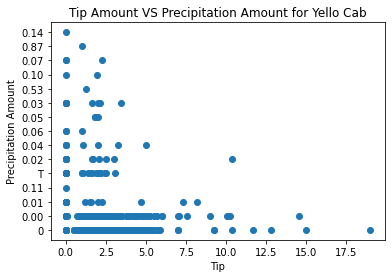

In [65]:
vis6_dataframe = get_data_for_tip_precipitation()
tip_precipitation(vis6_dataframe)